# Basic Processing

This notebook applies basic processing to the raw-output of the tracker, as part of the creation of convenient data representations as discussed below.
This processing mainly includes **lanes-clustering** and creation of **location-oriented data-structure**
(additional processing was already done in Tracker.py as discussed below).

#### Data representation

For every video, the tracking process saves the tracks as 3 tables: x(frame,vehicle) (with most entries being nan, since each vehicle appears only in few frames), y(frame,vehicle), size(frame,vehicle).
This representation suffers from 2 main drawbacks:
- It is very raw and inconvenient for summarizing calculations.
- Since both axes (frames and vehicles) are inconsistent between different videos, the tables of the various videos cannot be concatenated together.

To handle both issues and allow efficient research, 2 additional data representations were built as summarized below.
Note that some of the processing was already done in the Tracker package for debugging issues, and was left there due to dependencies of previous notebooks.

| Structure | Keys | Values | Usage example | Preliminary processing | Source code |
| --- | --- | --- | --- | --- | --- |
| **Raw tracking logs** | time, vehicle | x, y | Get all detected locations of a car in a video | Non-linear transformation from pixels to meters | Tracker/Tracker.py |
| **Per-vehicle** | vehicle, road-interval | time, y, speed, etc. | Get speed distribution per some group of videos | Interpolation of x,y to grid points x1...xn | Tracker/Tracker.py |
| **Spatial** | time, lane, road-interval | number of vehicles, speed | Get speed distribution per lane | Clustering to lanes (using K-means with quantiles 10,30,50,70,90 as initial class-centers) | Analyzer/BasicProcessor.py |

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import BasicProcessor as bp

In [3]:
if '../Tracker' not in sys.path: sys.path.append('../Tracker')
import Tracker as t

In [4]:
mpl.rcParams.update({'font.size': 14})

In [145]:
video = '20190520_105429'
pathbase = Path(r'd:\media\videos\ayalon')
videopath = str(pathbase/f'{video:s}.mp4')

In [166]:
df, X, Y, S, N, W, H = t.read_video_summary(video, filtered=True)

## Lanes clustering

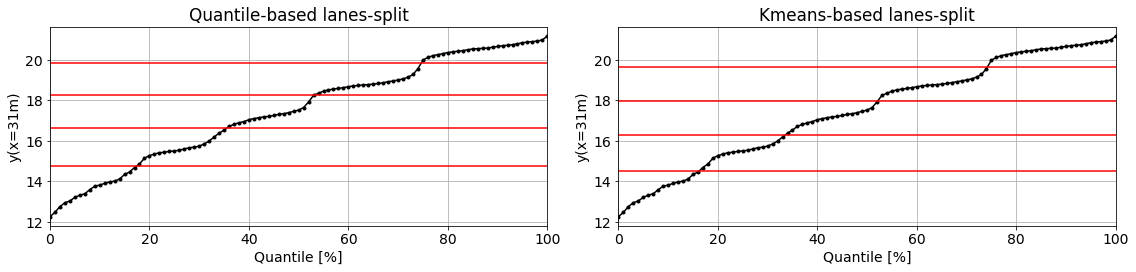

In [52]:
_, axs = plt.subplots(1,2, figsize=(16,4))

ax = axs[0]
cents = initial_centers
t.qplot(df.y_31, ax=ax, ylab='y(x=31m)', showmean=False)
ax.set_title('Quantile-based lanes-split')
for c1,c2 in zip(cents[:-1],cents[1:]):
    ax.axhline((c1+c2)/2, color='red')

ax = axs[1]
cents = kmeans.cluster_centers_
t.qplot(df.y_31, ax=ax, ylab='y(x=31m)', showmean=False)
ax.set_title('Kmeans-based lanes-split')
for c1,c2 in zip(cents[:-1],cents[1:]):
    ax.axhline((c1+c2)/2, color='red')

plt.tight_layout()

Near the bridge (x<=7), there's less visible area in the right lanes, thus the clustering is not reliable:

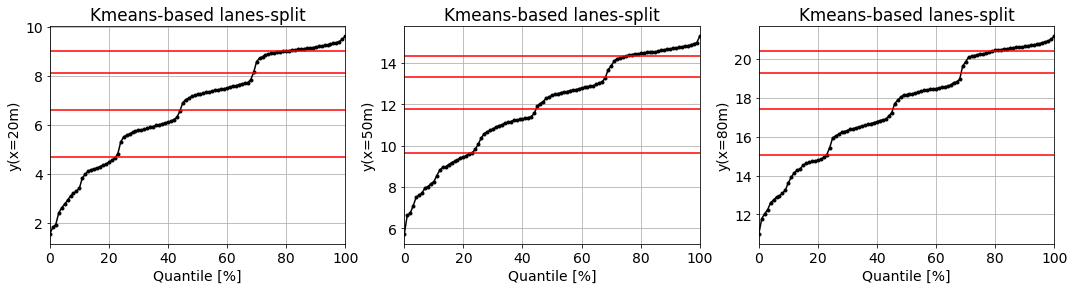

In [68]:
_, axs = plt.subplots(1,3,figsize=(18,4))
bp.cluster_lanes(df, show_lanes=[20,axs[0]])
bp.cluster_lanes(df, show_lanes=[50,axs[1]])
bp.cluster_lanes(df, show_lanes=[80,axs[2]]);

In [69]:
df

,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,avg_size,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
19,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,30,True,True,5.419062,...,1,1,1,1,1,1,1,1,1.0,1.0
18,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,40,True,True,4.693901,...,1,1,1,1,1,1,1,1,1.0,1.0
8,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,20,True,True,5.207388,...,2,2,2,2,2,2,2,2,2.0,2.0
22,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,21,True,False,4.333926,...,2,2,2,2,2,2,2,2,2.0,2.0
21,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,23,True,False,5.098568,...,3,3,3,3,3,3,3,3,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,27,True,False,4.299762,...,3,3,3,3,3,3,3,3,3.0,3.0
1365,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,30,True,True,4.862114,...,3,3,3,3,3,3,3,3,3.0,3.0
1372,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,28,True,False,5.090088,...,4,4,4,4,5,4,5,4,5.0,5.0
1380,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,27,True,False,4.995531,...,3,3,3,3,3,3,3,3,3.0,NaN


In [70]:
bp.cluster_lanes_for_all_videos(videos=[video])

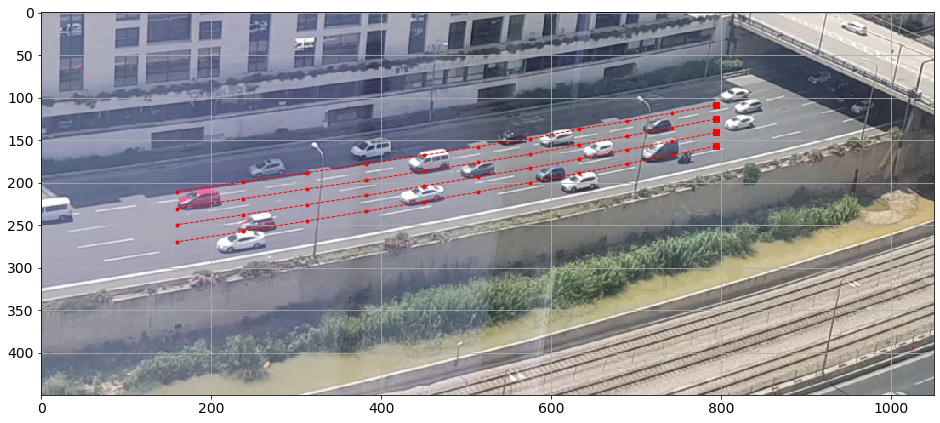

In [71]:
plt.figure(figsize=(16,8))
bp.plot_lanes(video, 0)
plt.grid()

#### Lane transitions - most of them are in the right lanes, near the entrances & exits:

In [23]:
lanes = df[[f'lane_{x:.0f}' for x in bp.X_REF]]
all_lanes = np.diff(lanes.values, axis=1).flatten()
transitions = Counter(all_lanes[np.logical_not(np.isnan(all_lanes))])
print(transitions)
df[(lanes.diff(axis=1).abs()>1).any(axis=1)]

Counter({0.0: 8227, 1.0: 108, -1.0: 95, -2.0: 1})


,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,avg_size,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
884,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,56,True,False,5.286919,...,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
n_transitions = np.sum([transitions[tr_size] for tr_size in transitions if tr_size!=0])
lane_transitions = pd.DataFrame(index=list(range(n_transitions)), columns=('x','lane_1','lane_2'))

i = 0
for car in lanes.index:
    for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:]):
        if np.logical_not(np.isnan(lanes.loc[car,f'lane_{x1:.0f}'])) and \
                np.logical_not(np.isnan(lanes.loc[car,f'lane_{x2:.0f}'])) and \
                lanes.loc[car,f'lane_{x1:.0f}'] != lanes.loc[car,f'lane_{x2:.0f}']:
            lane_transitions.iloc[i,0] = x1
            lane_transitions.iloc[i,1] = lanes.loc[car,f'lane_{x1:.0f}']
            lane_transitions.iloc[i,2] = lanes.loc[car,f'lane_{x2:.0f}']
            i += 1
            
lane_transitions

,x,lane_1,lane_2
0,74,1,2
1,50,2,1
2,38,3,4
3,44,2,3
4,38,2,1
...,...,...,...
199,38,3,2
200,26,1,2
201,32,3,2
202,20,2,1


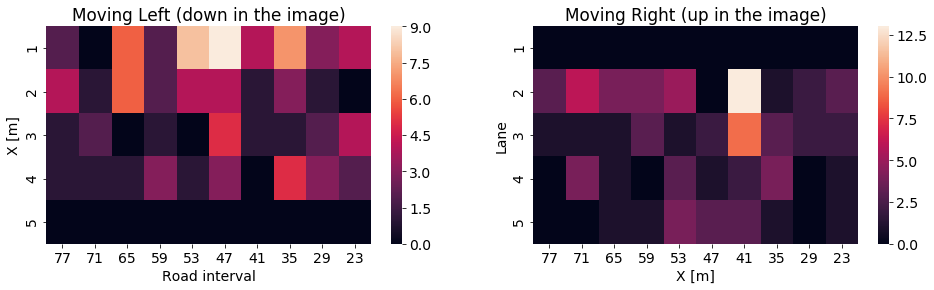

In [31]:
lane_transitions_d = lane_transitions[lane_transitions.lane_2>lane_transitions.lane_1]
lane_transitions_u = lane_transitions[lane_transitions.lane_2<lane_transitions.lane_1]
trans_per_cell_d = np.zeros((5,len(bp.X_REF)))
trans_per_cell_u = np.zeros((5,len(bp.X_REF)))
for i,l in enumerate(range(1,6)):
    for j,x0 in enumerate(bp.X_REF):
        trans_per_cell_d[i,j] = ((lane_transitions_d.x==x0) & (lane_transitions_d.lane_1==l)).sum()
        trans_per_cell_u[i,j] = ((lane_transitions_u.x==x0) & (lane_transitions_u.lane_1==l)).sum()

_, axs = plt.subplots(1,2, figsize=(16,4))

ax = axs[0]
# last x-interval is irrelevant because there can be no more transitions after it...
sns.heatmap(trans_per_cell_d[:,:-1],
            xticklabels=np.array((bp.X_REF[1:]+bp.X_REF[:-1])/2,dtype=int), yticklabels=1+np.arange(5), ax=ax)
ax.invert_xaxis()
ax.set_title('Moving Left (down in the image)')
ax.set_xlabel('Road interval')
ax.set_ylabel('X [m]')

ax = axs[1]
sns.heatmap(trans_per_cell_u[:,:-1],
            xticklabels=np.array((bp.X_REF[1:]+bp.X_REF[:-1])/2,dtype=int), yticklabels=1+np.arange(5), ax=ax)
ax.invert_xaxis()
ax.set_title('Moving Right (up in the image)')
ax.set_xlabel('X [m]')
ax.set_ylabel('Lane');

#### Lane transitions - all videos

In [ ]:
df = pd.read_csv(bp.DATA_DIR/'summary_per_car_filtered.csv')
trns = bp.get_lanes_transitions(df, notebook=True, save_to='lane_transitions', verbose=2)
print(trns.shape)
trns.head()

In [ ]:
bp.show_transitions(trns)

## Spatial summary

In [97]:
bp.save_spatial_summaries(videos=[video])

In [98]:
s = bp.merge_spatial_summaries(videos=[video], to_save=False)

In [99]:
s

,t,n_detections,n_tracks,n_x20to26_l1,v_x20to26_l1,vx_x20to26_l1,vy_x20to26_l1,n_x20to26_l2,v_x20to26_l2,vx_x20to26_l2,...,vx_x74to80_l3,vy_x74to80_l3,n_x74to80_l4,v_x74to80_l4,vx_x74to80_l4,vy_x74to80_l4,n_x74to80_l5,v_x74to80_l5,vx_x74to80_l5,vy_x74to80_l5
0,0.000000,20.0,19,0,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
1,0.266667,20.0,21,0,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,1,12.656952,12.383626,2.616151,0,NaN,NaN,NaN
2,0.533333,18.0,21,1,8.985662,8.833307,1.647667,0,NaN,NaN,...,NaN,NaN,1,12.656952,12.383626,2.616151,0,NaN,NaN,NaN
3,0.800000,19.0,20,1,8.985662,8.833307,1.647667,1,8.444815,8.303207,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
4,1.066667,19.0,18,0,NaN,NaN,NaN,1,8.444815,8.303207,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,432.533333,31.0,28,0,NaN,NaN,NaN,1,1.243838,1.241659,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
1623,432.800000,30.0,28,0,NaN,NaN,NaN,1,1.243838,1.241659,...,10.023725,1.864552,0,NaN,NaN,NaN,0,NaN,NaN,NaN
1624,433.066667,32.0,29,1,NaN,NaN,NaN,1,1.243838,1.241659,...,10.023725,1.864552,1,NaN,NaN,NaN,1,10.533358,10.308413,2.165237
1625,433.333333,29.0,29,1,NaN,NaN,NaN,1,1.243838,1.241659,...,10.023725,1.864552,1,NaN,NaN,NaN,1,10.533358,10.308413,2.165237


In [75]:
s.columns

Index(['t', 'n_detections', 'n_tracks', 'n_x20to26_l1', 'v_x20to26_l1',
       'n_x20to26_l2', 'v_x20to26_l2', 'n_x20to26_l3', 'v_x20to26_l3',
       'n_x20to26_l4',
       ...
       'n_x74to80_l1', 'v_x74to80_l1', 'n_x74to80_l2', 'v_x74to80_l2',
       'n_x74to80_l3', 'v_x74to80_l3', 'n_x74to80_l4', 'v_x74to80_l4',
       'n_x74to80_l5', 'v_x74to80_l5'],
      dtype='object', length=103)

## Run lanes-clustering and spatial-summary over all videos

In [225]:
bp.cluster_lanes_for_all_videos()

In [ ]:
# Save spatial summary with all tracks (including invalid ones)
bp.save_spatial_summaries(do_filter=False, notebook=True, verbose=1)
bp.merge_spatial_summaries(suffix='spatial_unfiltered', to_save=True, filename='summary_per_area_unfiltered');

In [ ]:
# Save spatial summary with filtered tracks
bp.save_spatial_summaries(do_filter=True, notebook=True, verbose=1)
bp.merge_spatial_summaries(suffix='spatial_filtered', to_save=True, filename='summary_per_area_filtered');

In [260]:
gc.collect()

41

#### Spatial summaries - sanity checks

In [261]:
s1 = pd.read_csv(bp.DATA_DIR/'summary_per_area_unfiltered.csv')
s2 = pd.read_csv(bp.DATA_DIR/'summary_per_area_filtered.csv')

Dimensions are *all frames* X *4 global columns + 100 cells in road*:

In [262]:
print(s1.shape, s1.shape)
s2.head()

(186746, 104) (186746, 104)


,video,t,n_detections,n_tracks,n_x20to26_l1,v_x20to26_l1,n_x20to26_l2,v_x20to26_l2,n_x20to26_l3,v_x20to26_l3,...,n_x74to80_l1,v_x74to80_l1,n_x74to80_l2,v_x74to80_l2,n_x74to80_l3,v_x74to80_l3,n_x74to80_l4,v_x74to80_l4,n_x74to80_l5,v_x74to80_l5
0,20190520_105429,0.000000,20.0,3,0,NaN,0,NaN,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,20190520_105429,0.266667,20.0,5,0,NaN,0,NaN,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2,20190520_105429,0.533333,18.0,5,0,NaN,0,NaN,1,12.164381,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,20190520_105429,0.800000,19.0,5,0,NaN,1,8.444815,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,20190520_105429,1.066667,19.0,5,0,NaN,1,8.444815,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


*Number of detections* is identical, but *number of tracks* is smaller in the filtered data-frame:

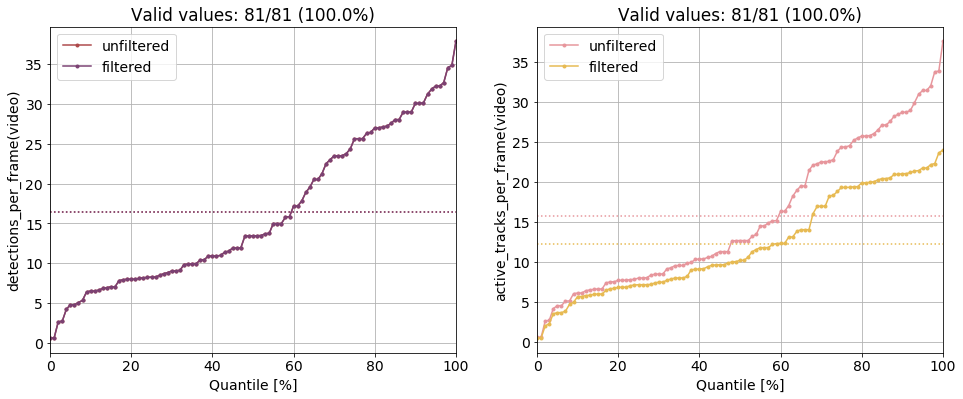

In [276]:
_, axs = plt.subplots(1,2,figsize=(16,6))

ax = axs[0]
t.qplots(pd.DataFrame({
    'unfiltered': s1.groupby('video')['n_detections'].mean().values,
    'filtered':   s2.groupby('video')['n_detections'].mean().values}), ax=ax)
ax.set_ylabel('detections_per_frame(video)')

ax = axs[1]
t.qplots(pd.DataFrame({
    'unfiltered': s1.groupby('video')['n_tracks'].mean().values,
    'filtered':   s2.groupby('video')['n_tracks'].mean().values}), ax=ax)
ax.set_ylabel('active_tracks_per_frame(video)');

Speeds distributions have reasonable scales and trends (similar over road intervals, larger in the lefter lanes):

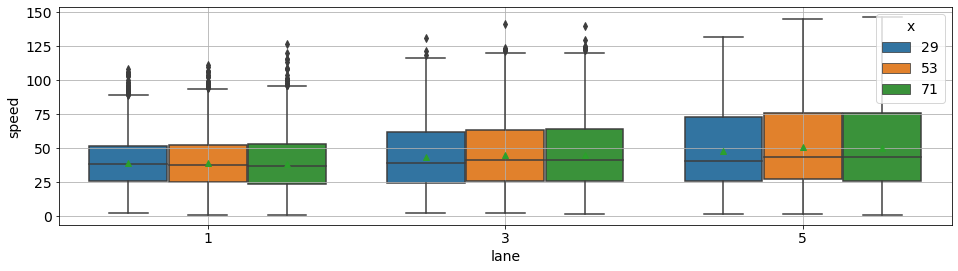

In [274]:
tmp = pd.DataFrame(columns=('lane','x','speed'))
for lane in (1,3,5):
    for x in (29,53,71):
        tmp = pd.concat((tmp, pd.DataFrame({'lane':lane, 'x':x, 'speed':3.6*s2[f'v_x{x-3:.0f}to{x+3:.0f}_l{lane:.0f}']})))
        
plt.figure(figsize=(16,4))
sns.boxplot(data=tmp, x='lane', hue='x', y='speed', showmeans=True)
#sns.violinplot(data=tmp, x='lane', hue='x', y='speed', inner='quart')
plt.grid()